In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
base_path = '/kaggle/input/mvtec-ad'  # Update this based on the actual dataset name in Kaggle

# Specify paths for training and testing
train_dir = os.path.join(base_path, 'cable/train/good')  # Example: 'bottle' category, 'good' images
test_dir = os.path.join(base_path, 'cable/test')  

In [3]:
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
    return np.array(images)

# Load training images
train_images = load_images_from_folder(train_dir)
print(f"Loaded {len(train_images)} training images with shape {train_images[0].shape}")


Loaded 224 training images with shape (128, 128, 3)


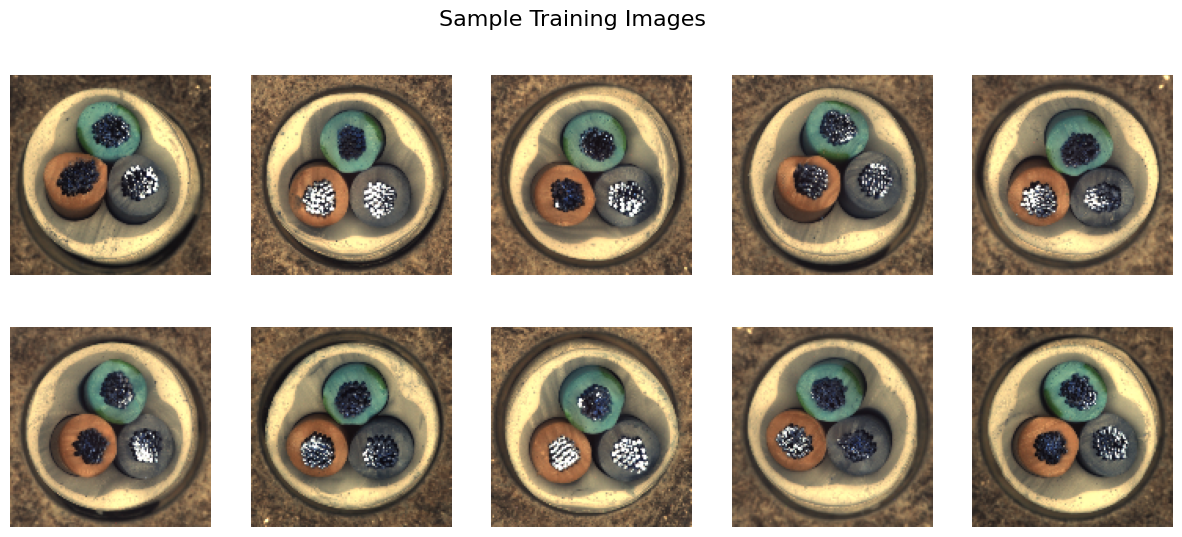

In [4]:
def visualize_samples(images, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    for i in range(rows * cols):
        if i >= len(images):
            break
        ax = axes[i // cols, i % cols]
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

visualize_samples(train_images, "Sample Training Images")


In [5]:
class MVTecDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]

# DataLoader
train_dataset = MVTecDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Training dataset size: {len(train_dataset)}")


Training dataset size: 224


In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim=3, latent_dim=100, img_size=128):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=1, padding=0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, input_dim, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return z, recon_x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=3, img_size=128):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(out.size(0), -1)

In [8]:
adversarial_loss_fn = nn.BCEWithLogitsLoss()
reconstruction_loss = nn.MSELoss()
latent_loss = nn.MSELoss()


In [9]:
latent_dim = 100
input_dim = 3
img_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(input_dim=input_dim, latent_dim=latent_dim, img_size=img_size).to(device)
discriminator = Discriminator(input_dim=input_dim, img_size=img_size).to(device)

# Optimizers
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [10]:
num_epochs = 50
for epoch in range(num_epochs):
    for i, imgs in enumerate(train_loader):
        imgs = imgs.to(device)

        ### Train Discriminator ###
        optimizer_D.zero_grad()

        # Real images
        real_validity = discriminator(imgs)
        real_labels = torch.ones_like(real_validity, device=device)
        real_loss = adversarial_loss_fn(real_validity, real_labels)

        # Fake images
        _, gen_imgs = generator(imgs)
        fake_validity = discriminator(gen_imgs.detach())
        fake_labels = torch.zeros_like(fake_validity, device=device)
        fake_loss = adversarial_loss_fn(fake_validity, fake_labels)

        # Total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        ### Train Generator ###
        optimizer_G.zero_grad()

        fake_validity = discriminator(gen_imgs)
        g_adv_loss = adversarial_loss_fn(fake_validity, real_labels)

        _, recon_imgs = generator(imgs)
        g_recon_loss = reconstruction_loss(recon_imgs, imgs)

        z, _ = generator(imgs)
        z_recon, _ = generator(recon_imgs)
        g_latent_loss = latent_loss(z, z_recon)

        g_loss = g_adv_loss + g_recon_loss + g_latent_loss
        g_loss.backward()
        optimizer_G.step()

        if i % 10 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

[Epoch 1/50] [Batch 0/7] [D loss: 1.4073] [G loss: 1.6124]
[Epoch 2/50] [Batch 0/7] [D loss: 1.4505] [G loss: 1.3586]
[Epoch 3/50] [Batch 0/7] [D loss: 1.1856] [G loss: 1.4380]
[Epoch 4/50] [Batch 0/7] [D loss: 1.0725] [G loss: 1.5098]
[Epoch 5/50] [Batch 0/7] [D loss: 1.1210] [G loss: 1.4918]
[Epoch 6/50] [Batch 0/7] [D loss: 1.2574] [G loss: 1.3513]
[Epoch 7/50] [Batch 0/7] [D loss: 1.3058] [G loss: 1.1195]
[Epoch 8/50] [Batch 0/7] [D loss: 1.2486] [G loss: 1.4319]
[Epoch 9/50] [Batch 0/7] [D loss: 1.2481] [G loss: 1.2061]
[Epoch 10/50] [Batch 0/7] [D loss: 1.2596] [G loss: 1.3631]
[Epoch 11/50] [Batch 0/7] [D loss: 1.2025] [G loss: 1.0707]
[Epoch 12/50] [Batch 0/7] [D loss: 1.3462] [G loss: 1.2394]
[Epoch 13/50] [Batch 0/7] [D loss: 1.2388] [G loss: 1.7062]
[Epoch 14/50] [Batch 0/7] [D loss: 1.1126] [G loss: 1.1366]
[Epoch 15/50] [Batch 0/7] [D loss: 1.1284] [G loss: 1.1991]
[Epoch 16/50] [Batch 0/7] [D loss: 1.1584] [G loss: 1.3042]
[Epoch 17/50] [Batch 0/7] [D loss: 1.3020] [G los

In [11]:
torch.save(generator.state_dict(), 'ganomaly_generator_cable.pth')
torch.save(discriminator.state_dict(), 'ganomaly_discriminator_cable.pth')


In [12]:
# Helper function to load test images (from earlier code)
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
    return np.array(images)

def load_test_images(test_root_dir, img_size=(128, 128)):
    """
    Load all test images from subfolders categorized by anomaly types.
    Parameters:
        test_root_dir (str): Path to the test directory containing subfolders.
        img_size (tuple): Target size to resize the images (width, height).
    Returns:
        dict: Dictionary with anomaly types as keys and lists of images as values.
    """
    test_data = {}
    for subfolder in os.listdir(test_root_dir):
        folder_path = os.path.join(test_root_dir, subfolder)
        if os.path.isdir(folder_path):  # Ensure it's a folder
            images = load_images_from_folder(folder_path, img_size)
            test_data[subfolder] = images
    return test_data

# Load test images
test_images = load_test_images(test_dir)
print(f"Loaded test images for categories: {list(test_images.keys())}")

# Test DataLoader Implementation
from torch.utils.data import DataLoader, Dataset

class TestDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Select a test category
test_category = 'good'  # Change this based on your dataset
if test_category not in test_images:
    raise ValueError(f"Test category '{test_category}' not found in test_images.")

test_data = test_images[test_category]  # Get images for the chosen category
test_dataset = TestDataset(test_data)  # Create PyTorch dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Confirm successful DataLoader creation
print(f"Loaded {len(test_dataset)} images for category '{test_category}'.")


Loaded test images for categories: ['cut_outer_insulation', 'good', 'cut_inner_insulation', 'cable_swap', 'bent_wire', 'missing_wire', 'missing_cable', 'poke_insulation', 'combined']
Loaded 58 images for category 'good'.


In [13]:
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def calculate_anomaly_scores(generator, test_loader, device):
    """
    Calculate reconstruction and latent space anomaly scores.

    Parameters:
        generator (nn.Module): The generator model (trained).
        test_loader (DataLoader): DataLoader for test dataset.
        device (torch.device): Device to perform computations on.

    Returns:
        np.ndarray: Reconstruction errors for all test samples.
        np.ndarray: Latent space errors for all test samples.
    """
    generator.eval()
    reconstruction_errors = []
    latent_errors = []

    with torch.no_grad():
        for imgs in tqdm(test_loader, desc="Calculating anomaly scores"):
            imgs = imgs.to(device)
            
            # Forward pass through generator
            z, recon_imgs = generator(imgs)
            z_recon, _ = generator(recon_imgs)
            
            # Compute reconstruction error (scalar per image)
            recon_error = F.mse_loss(recon_imgs, imgs, reduction='none').mean(dim=[1, 2, 3])
            reconstruction_errors.append(recon_error.cpu())
            
            # Compute latent space error (scalar per image)
            latent_error = F.mse_loss(z, z_recon, reduction='none').mean(dim=1)  # Average latent dimensions
            latent_errors.append(latent_error.cpu())

    # Concatenate tensors and convert to numpy arrays
    reconstruction_errors = torch.cat(reconstruction_errors).numpy()
    latent_errors = torch.cat(latent_errors).numpy()

    return reconstruction_errors, latent_errors


In [14]:
# Calculate anomaly scores
reconstruction_errors, latent_errors = calculate_anomaly_scores(generator, test_loader, device)

# Expand reconstruction_errors to match latent_errors
reconstruction_errors = np.expand_dims(reconstruction_errors, axis=(1, 2))
reconstruction_errors = np.tile(reconstruction_errors, (1, latent_errors.shape[1], latent_errors.shape[2]))

# Combine errors (weighted)
combined_scores = 0.5 * reconstruction_errors + 0.5 * latent_errors

# Print results (average over spatial dimensions if needed)
print(f"Average Reconstruction Error: {np.mean(reconstruction_errors):.4f}")
print(f"Average Latent Space Error: {np.mean(latent_errors):.4f}")
print(f"Average Combined Score: {np.mean(combined_scores):.4f}")


Calculating anomaly scores: 100%|██████████| 2/2 [00:00<00:00, 35.48it/s]

Average Reconstruction Error: 0.0350
Average Latent Space Error: 0.1070
Average Combined Score: 0.0710


In [15]:
import numpy as np

# If combined_scores has spatial dimensions, reduce it to a scalar per image
if combined_scores.ndim > 1:
    combined_scores = combined_scores.mean(axis=(1, 2))  # Average spatial dimensions

# Fixed threshold (example: 0.01)
threshold = 0.01

# Classify as anomaly or normal
anomaly_labels = [1 if score > threshold else 0 for score in combined_scores]  # 1 = anomaly, 0 = normal

# Dynamic threshold (95th percentile of normal scores)
dynamic_threshold = np.percentile(combined_scores, 95)
print(f"Dynamic Threshold: {dynamic_threshold:.4f}")


Dynamic Threshold: 0.0840


In [16]:
# Select an image from the test dataset
test_image_idx = 6# Change index as needed
input_image = test_data[test_image_idx]  # Original image (HWC format)

# Convert NumPy image to PyTorch tensor
input_tensor = torch.tensor(input_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

# Pass the image through the generator
generator.eval()
with torch.no_grad():
    _, reconstructed_image = generator(input_tensor)

# Convert reconstructed image back to NumPy (HWC format)
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()


In [17]:
# Compute the anomaly map (absolute difference)
anomaly_map = np.abs(input_image - reconstructed_image_np)

# Normalize the anomaly map to [0, 1] for visualization
anomaly_map = anomaly_map / anomaly_map.max()


In [18]:
import cv2

# Convert input image to 8-bit for overlaying
input_image_8bit = (input_image * 255).astype(np.uint8)

# Convert anomaly map to heatmap (apply colormap)
anomaly_heatmap = cv2.applyColorMap((anomaly_map * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Overlay heatmap on original image (blend)
overlay_image = cv2.addWeighted(input_image_8bit, 0.6, anomaly_heatmap, 0.4, 0)


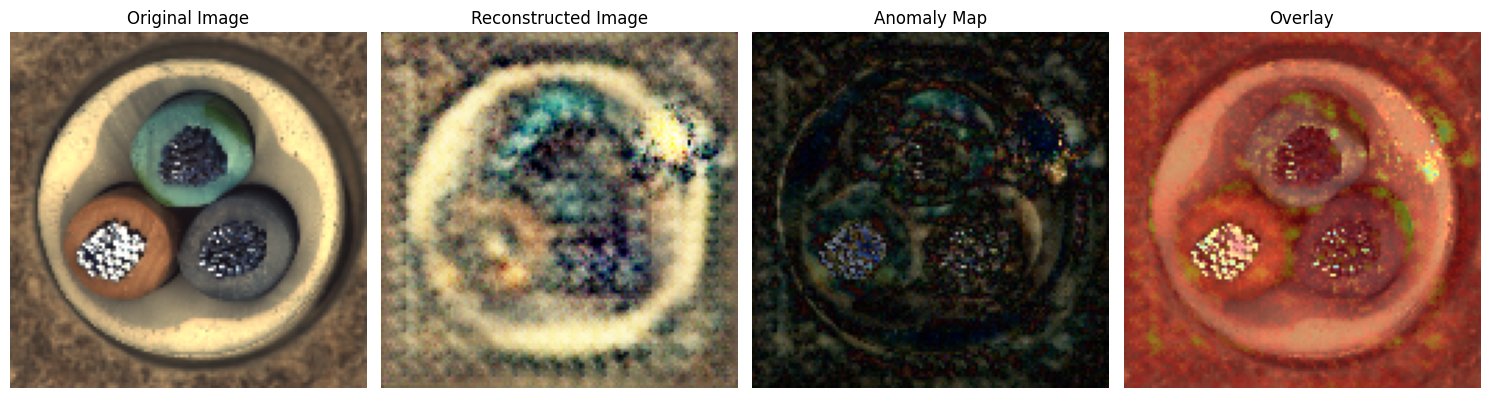

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(input_image)
plt.title("Original Image")
plt.axis("off")

# Reconstructed image
plt.subplot(1, 4, 2)
plt.imshow(reconstructed_image_np)
plt.title("Reconstructed Image")
plt.axis("off")

# Anomaly map
plt.subplot(1, 4, 3)
plt.imshow(anomaly_map, cmap='hot')
plt.title("Anomaly Map")
plt.axis("off")

# Overlay
plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


In [20]:
cv2.imwrite("anomaly_overlay.jpg", cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))


True